# Simple artificial neural network
The aim of this notebook is to write a simple and easy to use artificial neural network.
We'll start by importing the only necessary library for the implementation to work.

In [1]:
import numpy as np

We can separate the implementation in two classes:
- FCN (Fully connected layer): This class will contain the weights and biases for each layer.
    It will also be responsible for calculating the output for the layer given some inputs,
    as well as calculating the delta to update the weights and backpropagate the error
    to previous layers.
- ANN (Artificial neural network): This class creates a fully connected artificial neural network consisting of
    layers made of FCN objects. It's responsible for implementing SGD, train and predict methods.

In [2]:
# Fully connected layer
class FCN:
    def __init__(self, input_nodes, hidden_nodes, activation_fn, use_bias=False):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.activation_function = activation_fn
        
        self.weights = np.random.normal(0.0, self.input_nodes**-0.5,
                                        (self.input_nodes, self.hidden_nodes))
        
        self.use_bias = use_bias
        if self.use_bias:
            self.bias = np.zeros((1, self.hidden_nodes))
            self.delta_bias = np.zeros(self.bias.shape)
                                        
        self.delta_weights = np.zeros(self.weights.shape)
        
    def initialize_delta(self):
        self.delta_weights = np.zeros(self.weights.shape)
        if self.use_bias:
            self.delta_bias = np.zeros(self.bias.shape)
            
    def update_weights(self, lr, n_features):
        self.weights += lr * self.delta_weights / n_features
        if self.use_bias:
            self.bias += lr * self.delta_bias / n_features
                                        
    def forward(self, features):
        self.input = features
        self.output = np.dot(features, self.weights)
        if self.use_bias:
            self.output += self.bias
        if self.activation_function is not None:
            self.output = self.activation_function(self.output)
        return self.output
        
    def backprop(self, error, first_layer=False):
        # Calculate delta to update weights
        #print('Input shape:', self.input.T.shape, 'Error shape:', error.shape)
        self.delta_weights += np.dot(self.input.T, error)
        if self.use_bias:
            self.delta_bias += error
        # If it's not the first layer, calculate contribution to error
        # to pass to previous layer. Else save up computation time.
        if not first_layer:
            layer_error = np.dot(error, self.weights.T)
            # The derivative of the the sigmoid activation function is
            # f'(x) = f(x) * (1-f(x)). Thus, we can reuse f(x) which is
            # the input to the current layer
            layer_error *= self.input * (1 - self.input)
            return layer_error
        else:
            return None

In [3]:
# Artificial neural network
class ANN:
    '''
    ANN using mini-batch SGD
    '''
    def __init__(self, input_nodes, hidden_layers, hidden_nodes, output_nodes, learning_rate, use_bias=False):
        # Set class variables
        self.input_nodes = input_nodes
        self.hidden_layers = hidden_layers
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        # Define sigmoid activation function
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        
        # Initialize net
        self.layers = [FCN(input_nodes, hidden_nodes, self.activation_function, use_bias)] + \
            [FCN(hidden_nodes, hidden_nodes, self.activation_function, use_bias) for i in range(hidden_layers-1)] + \
            [FCN(hidden_nodes, output_nodes, None, use_bias)]
            
    def _forward(self, X):
        input_x = X
        for layer in self.layers:
            output = layer.forward(input_x)
            input_x = output
        return output
            
    def _backprop(self, output, target):
        error = target - output
        for i, layer in enumerate(reversed(self.layers)):
            if i<len(self.layers)-1:
                layer_error = layer.backprop(error)
                error = layer_error
                assert error is not None
            else:
                # Skip error calculation for backprop on first layer
                # since it's connected to inputs
                assert layer.backprop(error, first_layer=True) is None
                
    def _initialize_deltas(self):
        for layer in self.layers:
            layer.initialize_delta()
                
    def _update_weights(self, n_samples):
        for layer in self.layers:
            layer.update_weights(self.lr, n_samples)

    def train(self, features, targets):
        ''' 
        Train the network on batch of features and targets. 
        
        Arguments
        ---------

        features: numpy 2D array, each row is one data record, each column is a feature
        targets: numpy 1D array of target values
        
        '''
        
        if len(features.shape) != 2:
            raise ValueError('Features dimensions do not match. Correct ' +\
                              'shape should be (n_samples, n_samples).')
        if len(targets.shape) != 1:
            raise ValueError('Targets dimensions do not match. Correct '  +\
                              'shape should be (n_samples,).')
        if features.shape[0] != targets.shape[0]:
            raise ValueError('Features and targets have different amount of samples.')
        
        features = features[:, None]
        n_samples = features.shape[0]
        # Reset delta for every layer before training with new batch
        self._initialize_deltas()
            
        # Start training
        for X, y in zip(features, targets):
            # Forward pass
            output = self._forward(X)
                
            # Backpropagation
            self._backprop(output, y)
            
        # Update weights after training with batch
        self._update_weights(n_samples)
            
    def predict(self, features):
        ''' 
        Make predictions based on input features.
        
        Arguments
        ---------

        features: numpy 2D array, each row is one data record, each column is a feature

        '''
        if len(features.shape) != 2:
            raise ValueError('Features dimensions do not match. Correct ' +\
                              'shape should be (n_samples, n_samples).')
        if features.shape[1] != self.input_nodes:
            raise ValueError('Number of input features do not match training ' +\
                             'number of features (' + str(features.shape[1]) +\
                             ' != ' + str(self.input_nodes) + ')')
                            
        return self._forward(features)

# Load dataset, train and test
We will now load, train and test on the Iris dataset, although the Sonar dataset is also included and can be used instead.

First let's import the necessary libraries to read, preprocess and split the data.

In [4]:
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

Now we will create 2 functions to calculate mean square error for the model loss and another one to calculate the accuracy of the model.

In [5]:
def MSE(labels, predicted):
    return np.mean((labels-predicted)**2)
def acuracy(labels, predicted):
    return (labels == predicted.round()).sum()*100/labels.shape[0]

Read data from dataset, encode the labels and split into training (70%) and test (30%) data.

In [6]:
with open('iris.data', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='\"', quoting=csv.QUOTE_NONNUMERIC)
    X = []
    y = []
    for row in reader:
        X.append(row[:-1])
        y.append(row[-1])
    
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Define hyperparameters and create the ANN.

We will also create a get_batches function to create batches that we'll use for mini-batch SGD.

In [7]:
learning_rate = 0.4
hidden_layers = 1
hidden_nodes = 8
output_nodes = 1
use_bias = False

ann = ANN(X_train.shape[1], hidden_layers, hidden_nodes, output_nodes,
          learning_rate, use_bias)

def get_batches(X, y, batch_size=32):
    for batch in range(0, len(X), batch_size):
        yield X[batch:batch+batch_size], y[batch:batch+batch_size]

Define the number of epochs that we want to train for. We will use all the training data on each training step fed on mini-batches.

We will also calculate the training and test loss and accuracy to plot them later.

In [8]:
epochs = 1000
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
for e in range(epochs):
    for batch_x, batch_y in get_batches(X_train, y_train):
        ann.train(batch_x, batch_y)
        
    train_acc = acuracy(y_train[:, None], ann.predict(X_train))
    test_acc = acuracy(y_test[:, None], ann.predict(X_test))
    train_loss = MSE(y_train, ann.predict(X_train).T)
    test_loss = MSE(y_test, ann.predict(X_test).T)
    if e%100 == 0:
        print('Epoch', e, ':')
        print('Training loss:', train_loss, 'Training accuracy:', train_acc)
        print('Test loss:', test_loss, 'Test accuracy:', test_acc)
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 0 :
Training loss: 0.311888169454 Training accuracy: 66.6666666667
Test loss: 0.336929637196 Test accuracy: 64.4444444444
Epoch 100 :
Training loss: 0.0790841490826 Training accuracy: 89.5238095238
Test loss: 0.085709135804 Test accuracy: 88.8888888889
Epoch 200 :
Training loss: 0.0498537319624 Training accuracy: 94.2857142857
Test loss: 0.0583924203539 Test accuracy: 88.8888888889
Epoch 300 :
Training loss: 0.0404035552179 Training accuracy: 96.1904761905
Test loss: 0.0507556710008 Test accuracy: 91.1111111111
Epoch 400 :
Training loss: 0.0348858945154 Training accuracy: 96.1904761905
Test loss: 0.0474010553065 Test accuracy: 93.3333333333
Epoch 500 :
Training loss: 0.031518845781 Training accuracy: 97.1428571429
Test loss: 0.0459783501768 Test accuracy: 93.3333333333
Epoch 600 :
Training loss: 0.0292651367002 Training accuracy: 98.0952380952
Test loss: 0.0453444875901 Test accuracy: 93.3333333333
Epoch 700 :
Training loss: 0.0275024556778 Training accuracy: 98.0952380952
Test l

# Visualize loss and learning curves
Let's print the loss and the accuracy of the model to see if it performs well!

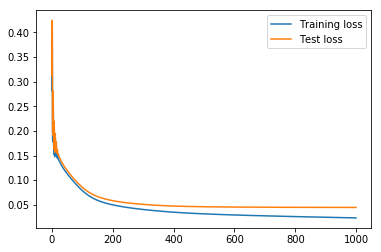

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
_ = plt.ylim()

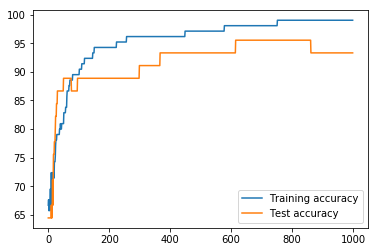

In [10]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.legend()
_ = plt.ylim()

Let's predict the output of the test set to see how it looks like.

In [11]:
print(ann.predict(X_test))

[[  1.47495828e+00]
 [  8.99629219e-01]
 [  1.54229526e+00]
 [  1.58228187e+00]
 [  9.02619572e-01]
 [ -2.55937918e-02]
 [  2.04492545e+00]
 [ -2.64806008e-02]
 [  9.07951919e-01]
 [ -4.44604707e-03]
 [  1.12282287e+00]
 [  1.51609341e+00]
 [  1.02925269e+00]
 [  1.94967460e+00]
 [  2.02928473e+00]
 [  7.84369242e-01]
 [  8.62400351e-01]
 [  9.32435494e-04]
 [  9.94552421e-03]
 [  2.02504861e+00]
 [  1.78919130e+00]
 [  2.01397186e+00]
 [ -2.69694944e-02]
 [  8.79041815e-03]
 [  1.99342943e+00]
 [ -1.12448977e-02]
 [  1.95583907e+00]
 [  9.35465415e-01]
 [  1.07551153e+00]
 [  9.81717296e-01]
 [  1.92339269e+00]
 [ -4.33052070e-02]
 [  8.95330131e-01]
 [ -2.28542942e-02]
 [  1.52442920e+00]
 [ -3.41680070e-02]
 [  1.83779042e+00]
 [  9.03781341e-01]
 [  6.60045409e-03]
 [  1.16875590e-02]
 [  1.96400889e+00]
 [ -3.96173858e-03]
 [  1.99940265e+00]
 [  1.20085720e+00]
 [  2.04153014e+00]]
